# Notebook on recommending a location to start a ***Coffee Shop*** in Cape Town

## 1. Installing and importing packages and libraries

In [5]:
#!pip install geopy

In [6]:
#!pip install wordcloud

In [7]:
#!conda install -c conda-forge folium=0.5.0 --yes

In [1]:
import pandas as pd
import numpy as np

#importing files
import types
from ibm_botocore.client import Config
import ibm_boto3

#webscraping
import requests
from bs4 import BeautifulSoup

#Foursquare
import json
from pandas.io.json import json_normalize

#geographical information
from geopy.geocoders import Nominatim

#visualization
import matplotlib
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import folium
from wordcloud import WordCloud, STOPWORDS
%matplotlib inline

#clustering
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans

#calculating distance
from math import sin, cos, sqrt, atan2,radians

---------------------------------------------------------------------------------------------------------------------

## 2. Reading the data into pandas dataframes and cleaning the data

### A. Data on Post Codes of South Africa, in the data they are represented as ***'Street Codes'***

In [5]:
#read csv file (IBM Cloud-style) and put the data in a dataframe
def __iter__(self): return 0

client_*** = ibm_boto3.client(service_name='s3',
    ibm_api_key_id=***,
    ibm_auth_endpoint=***,
    config=Config(signature_version='oauth'),
    endpoint_url='https://s3.eu-geo.objectstorage.service.networklayer.com')

body = client_***.get_object(Bucket='coffeeincapetowndatasciencespecia-donotdelete-pr-rzomrvulhjlqau',Key='Post Office ZA.csv')['Body']
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

In [6]:
#take a look at the dataframe
Post_Office = pd.read_csv(body)
Post_Office.head(10)

,SUBURB,BOX-CODE,STR-CODE,AREA
0,AALWYNFLEUR,NaN,6670,RIVERSDALE
1,AANDRUS,NaN,9301,BLOEMFONTEIN
2,ABAPHEHLI,4126,NaN,DOONSIDE
3,ABBOTSDALE,NaN,7300,MALMESBURY
4,ABBOTSFORD,5210,5241,EAST LONDON
5,ABBOTSFORD,NaN,2192,JOHANNESBURG
6,ABBOTSPOORT,608,NaN,POTGIETERSRUS
7,ABC,NaN,6242,KWANOBUHLE
8,ABEL,884,884,POLOKWANE
9,ABERDEEN,6270,6270,ABERDEEN


In [7]:
#let's have a look at the size of the dataframe
Post_Office.shape

(21713, 4)

In [8]:
#I only need the Street Codes of Cape Town so I select Cape Town as Area
Post_Office_CT = Post_Office.loc[Post_Office['AREA'].isin(['CAPE TOWN'])]

In [9]:
Post_Office_CT.head(10)

,SUBURB,BOX-CODE,STR-CODE,AREA
535,ATHLONE,7760,7764,CAPE TOWN
538,ATHLONE INDUSTRIA 1,NaN,7764,CAPE TOWN
539,ATHLONE INDUSTRIA 2,NaN,7764,CAPE TOWN
716,BAKOVEN,NaN,8005,CAPE TOWN
752,BANTRY BAY,NaN,8005,CAPE TOWN
753,BANTRYBAAI,NaN,8005,CAPE TOWN
1030,BELLVILLE,7535,7530,CAPE TOWN
1184,BERGVLIET,7864,7945,CAPE TOWN
1916,BOTHASIG,7406,7441,CAPE TOWN
2031,BRACKENFELL,7561,7560,CAPE TOWN


In [10]:
#let's see how the dataframe looks now
Post_Office_CT.shape

(204, 4)

In [11]:
#dropping the columns 'Box code' and 'Area', I don't need them
Suburbs_CT = Post_Office_CT.drop(['BOX-CODE', 'AREA'], axis = 1)

In [12]:
Suburbs_CT.head(10)

,SUBURB,STR-CODE
535,ATHLONE,7764
538,ATHLONE INDUSTRIA 1,7764
539,ATHLONE INDUSTRIA 2,7764
716,BAKOVEN,8005
752,BANTRY BAY,8005
753,BANTRYBAAI,8005
1030,BELLVILLE,7530
1184,BERGVLIET,7945
1916,BOTHASIG,7441
2031,BRACKENFELL,7560


In [13]:
#checking how many unique Suburbs and Street Codes there are in the dataframe
print('There are {} different Suburbs'.format(Suburbs_CT['SUBURB'].unique().shape[0]))
print('and {} unique Street Codes'.format(Suburbs_CT['STR-CODE'].unique().shape[0]))

There are 204 different Suburbs
and 27 unique Street Codes


In [14]:
#since there are several Suburbs sharing the same Street Code, I aggregate them
Suburbs_grouped_df = Suburbs_CT.groupby(['STR-CODE']).agg(', '.join)

CT_df = Suburbs_grouped_df.reset_index()
CT_df.head()

,STR-CODE,SUBURB
0,7100,"EERSTE RIVER, EERSTERIVIER"
1,7405,"MAITLAND, PAARDEN ISLAND, PAARDENEILAND, PINEL..."
2,7441,"BOTHASIG, EDGEMEAD, MELKBOS, MELKBOSSTRAND, MI..."
3,7455,"LANGA, LANGA ZONE 1, LANGA SONE 1, LANGA ZONE ..."
4,7460,MONTE VISTA


In [15]:
#check the datatypes, I need the Street Codes to be integers for future reference
CT_df.dtypes

STR-CODE    object
SUBURB      object
dtype: object

In [16]:
#adjusting the dtype of column 'Street Codes'
CT_df['STR-CODE'] = CT_df['STR-CODE'].astype(int)

In [17]:
#check if it worked
CT_df.dtypes

STR-CODE     int64
SUBURB      object
dtype: object

### B. Data on geographical coordinates of the Street Codes in Cape Town

In [18]:
#read csv file and put data in a dataframe
body = client_***.get_object(Bucket='coffeeincapetowndatasciencespecia-donotdelete-pr-rzomrvulhjlqau',Key='latlong.csv')['Body']
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

latlong_df = pd.read_csv(body)
latlong_df.head()

,STR-CODE,Latitude,Longitude
0,7100,-33.987809,18.667149
1,7405,-33.926604,18.498313
2,7441,-33.844994,18.522595
3,7455,-33.944727,18.532317
4,7460,-33.908873,18.550382


In [19]:
latlong_df.head()

,STR-CODE,Latitude,Longitude
0,7100,-33.987809,18.667149
1,7405,-33.926604,18.498313
2,7441,-33.844994,18.522595
3,7455,-33.944727,18.532317
4,7460,-33.908873,18.550382


### C. Merging the 2 datasets into a new dataframe with all the information

In [20]:
#now merge the 2 tables so I end up with a dataframe on Street Codes, grouped Suburbs and the Latitude and Longitude values of the grouped Suburbs
Capetown_ll = CT_df.join(latlong_df.set_index('STR-CODE'), on='STR-CODE')
Capetown_ll

,STR-CODE,SUBURB,Latitude,Longitude
0,7100,"EERSTE RIVER, EERSTERIVIER",-33.987809,18.667149
1,7405,"MAITLAND, PAARDEN ISLAND, PAARDENEILAND, PINEL...",-33.926604,18.498313
2,7441,"BOTHASIG, EDGEMEAD, MELKBOS, MELKBOSSTRAND, MI...",-33.844994,18.522595
3,7455,"LANGA, LANGA ZONE 1, LANGA SONE 1, LANGA ZONE ...",-33.944727,18.532317
4,7460,MONTE VISTA,-33.908873,18.550382
5,7490,MATROOSFONTEIN,-33.955570,18.587988
6,7500,PAROW,-33.891997,18.586241
7,7530,BELLVILLE,-33.879257,18.631784
8,7550,DURBANVILLE,-33.840950,18.659587
9,7560,BRACKENFELL,-33.875597,18.693069


In [21]:
#the last row is a Street Code for the whole city of Cape Town and not a specific (grouped) Suburb so I can drop that row
Capetown_ll = Capetown_ll.dropna()

In [22]:
print('The final shape of the Capetown_ll dataframe is:', Capetown_ll.shape)
print('')
Capetown_ll

The final shape of the Capetown_ll dataframe is: (25, 4)



,STR-CODE,SUBURB,Latitude,Longitude
0,7100,"EERSTE RIVER, EERSTERIVIER",-33.987809,18.667149
1,7405,"MAITLAND, PAARDEN ISLAND, PAARDENEILAND, PINEL...",-33.926604,18.498313
2,7441,"BOTHASIG, EDGEMEAD, MELKBOS, MELKBOSSTRAND, MI...",-33.844994,18.522595
3,7455,"LANGA, LANGA ZONE 1, LANGA SONE 1, LANGA ZONE ...",-33.944727,18.532317
4,7460,MONTE VISTA,-33.908873,18.550382
5,7490,MATROOSFONTEIN,-33.955570,18.587988
6,7500,PAROW,-33.891997,18.586241
7,7530,BELLVILLE,-33.879257,18.631784
8,7550,DURBANVILLE,-33.840950,18.659587
9,7560,BRACKENFELL,-33.875597,18.693069


#### ***Note: I will use the Street Codes for further analysis. The corresponding suburbs will be referred to at the end of this notebook.***

---------------------------------------------------------------------------------------------------------------------------------------------------------------

## 3. Visualization of the Street Codes based on their corresponding geographical coordinates

In [23]:
#create an instance of Geolocator to get the geographical coordinates of Cape Town
address = 'Cape Town, South Africa'
geolocator = Nominatim(user_agent = 'capetown_explorer')
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geographical coordinates of Cape Town are: lat = {}, long = {}.'.format(latitude, longitude))

The geographical coordinates of Cape Town are: lat = -33.928992, long = 18.417396.


In [24]:
#create a map of Cape Town and add the Street Codes as circle markers
map_Cape_Town = folium.Map(location=[latitude, longitude], zoom_start = 10, width = 800, height = 500)

for lat, lng, strcode in zip(Capetown_ll['Latitude'], Capetown_ll['Longitude'], Capetown_ll['STR-CODE']):
    label = '{}'.format(strcode)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng], radius = 6, popup = label,
        color = 'blue', fill = True, fill_color = 'yellow',
        fill_opacity = 0.6, parse_html = False).add_to(map_Cape_Town)

map_Cape_Town

--------------------------------------------------------------------------------------------------------------------------------------------------------------

## 4. Using Foursquare API to retrieve information on venues in Cape Town

In [25]:
#define client id, client secret and version to be able to use Foursquare API
client_id = 'XT3Q5AEWFGANGCMJJXJTGPFKVIL1RRCUARX4XN0550QK3BLK'
client_secret = 'BB0L40BDLBJMJROBYGSLPRULZ31QICHJXAYTXX4LWJSJPDSE'
version = '20180605'

### A. Exploring the first Street Code of Cape Town

In [26]:
print('The 1st Street Code in Cape Town is:', Capetown_ll.loc[0, 'STR-CODE'])

The 1st Street Code in Cape Town is: 7100


In [27]:
#get the coordinates of Street Code 7100
latitude = Capetown_ll.loc[0, 'Latitude']
longitude = Capetown_ll.loc[0, 'Longitude']
strcode = Capetown_ll.loc[0, 'STR-CODE']
print('The coordinates of Street Code {} are: lat {} and long {}'.format(strcode, latitude, longitude))

The coordinates of Street Code 7100 are: lat -33.987809000000006 and long 18.667149


In [28]:
#get the venues that are in Street Code 7100 within a radius of 2000m using Foursquare API
radius = 2000
limit = 100

url = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&ll={},{}&v={}&radius={}&limit={}'.format(client_id, client_secret, latitude, longitude, version, radius, limit)
url

'https://api.foursquare.com/v2/venues/explore?client_id=XT3Q5AEWFGANGCMJJXJTGPFKVIL1RRCUARX4XN0550QK3BLK&client_secret=BB0L40BDLBJMJROBYGSLPRULZ31QICHJXAYTXX4LWJSJPDSE&ll=-33.987809000000006,18.667149&v=20180605&radius=2000&limit=100'

In [29]:
results = requests.get(url).json()

#extract the categories of the venues
def get_category_type(row):
    try:
        categories_list=row['categories']
    except:
        categories_list=row['venue.categories']
    
    if len(categories_list)==0:
        return None
    else:
        return categories_list[0]['name']

In [30]:
#get the information I need from the json file and change it into a dataframe
venues = results['response']['groups'][0]['items']
nearby_venues = json_normalize(venues)

filteres_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

,count,items,referralId,categories,id,address,cc,city,country,distance,formattedAddress,labeledLatLngs,lat,lng,postalCode,state,name,count,groups
0,0,"[{'summary': 'This spot is popular', 'type': '...",e-0-4e93e83002d5a677b06d13ba-0,Arts & Crafts Store,4e93e83002d5a677b06d13ba,NaN,ZA,NaN,iNingizimu Afrika,738,[iNingizimu Afrika],"[{'label': 'display', 'lat': -33.9943976171197...",-33.994398,18.668121,NaN,NaN,Airport Mall,0,[]
1,0,"[{'summary': 'This spot is popular', 'type': '...",e-0-59bb714889e4903cca0d97d6-1,Print Shop,59bb714889e4903cca0d97d6,"1 Inez Avenue, Delft Animal Centre, Brentwood ...",ZA,iKapa,iNingizimu Afrika,1238,"[1 Inez Avenue, Delft Animal Centre, Brentwood...","[{'label': 'display', 'lat': -33.9846611022949...",-33.984661,18.654280,7100,Western Cape,Allrich Trading (Pty) Ltd,0,[]
2,0,"[{'summary': 'This spot is popular', 'type': '...",e-0-4e0b48c452b1fe83d54b9e09-2,Liquor Store,4e0b48c452b1fe83d54b9e09,Gugulethu Square,ZA,NaN,iNingizimu Afrika,1772,"[Gugulethu Square, iNingizimu Afrika]","[{'label': 'display', 'lat': -33.9954411792948...",-33.995441,18.650288,NaN,NaN,Shoprite Liquor Shop,0,[]
3,0,"[{'summary': 'This spot is popular', 'type': '...",e-0-4f8e459ee4b0d35b7febbacb-3,Pool,4f8e459ee4b0d35b7febbacb,Voorbrug Street,ZA,Delft,iNingizimu Afrika,1856,"[Voorbrug Street, Delft, 7100, iNingizimu Afrika]","[{'label': 'display', 'lat': -33.9759639740638...",-33.975964,18.652997,7100,Western Cape,Delft Swimming Pool,0,[]
4,0,"[{'summary': 'This spot is popular', 'type': '...",e-0-4f907ab1e4b078f4ace4e05a-4,Soccer Field,4f907ab1e4b078f4ace4e05a,Welgelegen Street,ZA,Delft,iNingizimu Afrika,1904,"[Welgelegen Street, Delft, 7100, iNingizimu Af...","[{'label': 'display', 'lat': -33.9753547237394...",-33.975355,18.652997,7100,Western Cape,Voorbrug Sports Field,0,[]


In [31]:
print('{} venues were returned by Foursquare.'.format(nearby_venues.shape[0]))

6 venues were returned by Foursquare.


### B. Retrieving the information from Foursquare on all Street Codes in Cape Town

In [32]:
#create a function to repeat the same process for all the Street Codes
def getNearbyVenues(names, latitudes, longitudes, radius=2000, limit=100):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            client_id, 
            client_secret, 
            version, 
            lat, 
            lng, 
            radius, 
            limit)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    Capetown_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    Capetown_venues.columns = ['Street Code', 
                  'Street Code lat', 
                  'Street Code lng', 
                  'Venue', 
                  'Venue lat', 
                  'Venue lng', 
                  'Category']
    
    return(Capetown_venues)

In [33]:
#create a new dataframe and run the above function on each neighbourhood
Capetown_venues = getNearbyVenues(names=Capetown_ll['STR-CODE'],
                                   latitudes=Capetown_ll['Latitude'],
                                   longitudes=Capetown_ll['Longitude'])

7100
7405
7441
7455
7460
7490
7500
7530
7550
7560
7700
7708
7750
7764
7780
7784
7785
7800
7806
7925
7941
7945
7975
8001
8005


In [34]:
#check the dataframe
print('Shape Cape Town venues dataframe is:', Capetown_venues.shape)
Capetown_venues.head(10)

Shape Cape Town venues dataframe is: (802, 7)


,Street Code,Street Code lat,Street Code lng,Venue,Venue lat,Venue lng,Category
0,7100,-33.987809,18.667149,Airport Mall,-33.994398,18.668121,Arts & Crafts Store
1,7100,-33.987809,18.667149,Allrich Trading (Pty) Ltd,-33.984661,18.654280,Print Shop
2,7100,-33.987809,18.667149,Shoprite Liquor Shop,-33.995441,18.650288,Liquor Store
3,7100,-33.987809,18.667149,Delft Swimming Pool,-33.975964,18.652997,Pool
4,7100,-33.987809,18.667149,Voorbrug Sports Field,-33.975355,18.652997,Soccer Field
5,7100,-33.987809,18.667149,ADV Glass & Aluminium,-34.003717,18.676383,Home Service
6,7405,-33.926604,18.498313,Merrypak & Print,-33.928847,18.500087,Arts & Crafts Store
7,7405,-33.926604,18.498313,Magica Roma,-33.940149,18.497787,Italian Restaurant
8,7405,-33.926604,18.498313,Woolworths,-33.932966,18.510301,Grocery Store
9,7405,-33.926604,18.498313,Hoghouse,-33.929770,18.500975,BBQ Joint


In [35]:
#show how many unique categories there are in the returned venues
print('There are {} unique venue categories.'.format(len(Capetown_venues['Category'].unique())))

There are 159 unique venue categories.


### C. Take a look at the top 10 venue categories found around Cape Town

In [36]:
#retrieve the Top 10 venue categories in Cape Town
CT_Top10_venues = Capetown_venues.groupby('Category').count().sort_values(by='Venue', ascending = False).head(10).reset_index()
CT_Top10_venues.rename(columns = {'Venue':'Count'}, inplace = True)
CT_Top10_venues[['Category', 'Count']]

,Category,Count
0,Coffee Shop,49
1,Fast Food Restaurant,40
2,Café,38
3,Hotel,34
4,Grocery Store,31
5,Shopping Mall,28
6,Pizza Place,23
7,Restaurant,21
8,Steakhouse,20
9,Burger Joint,19


----------------------------------------------------------------------------------------------------------------------------------------------------------

## 5. Exploring the number of venues in each Street Code

### A. Check how many venues were returned for each Street Code

In [37]:
#group by Street Code and count the venues in each Street Code
Capetown_count = Capetown_venues.groupby('Street Code').count().reset_index()

In [38]:
Capetown_count.head(10)

,Street Code,Street Code lat,Street Code lng,Venue,Venue lat,Venue lng,Category
0,7100,6,6,6,6,6,6
1,7405,35,35,35,35,35,35
2,7441,10,10,10,10,10,10
3,7455,9,9,9,9,9,9
4,7460,39,39,39,39,39,39
5,7490,25,25,25,25,25,25
6,7500,18,18,18,18,18,18
7,7530,55,55,55,55,55,55
8,7550,36,36,36,36,36,36
9,7560,15,15,15,15,15,15


### B. Visualization of the number of venues per Street Code

In [39]:
#sort the number of venues per Street Code
Venue_sorted = Capetown_count.sort_values(by=['Venue'], ascending = False)

Text(0.5, 0, 'Street Code')

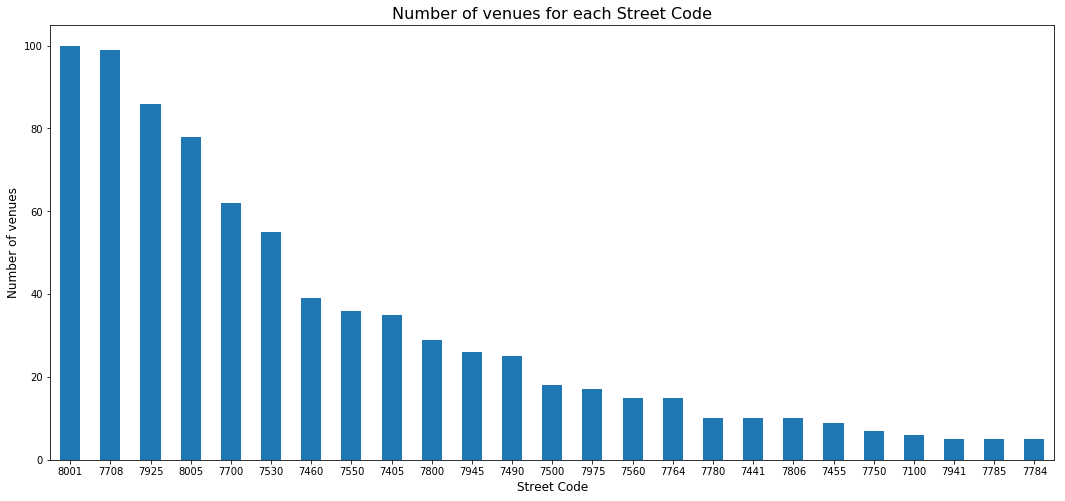

In [40]:
#plot the number of venues per Street Code (in descending order) to show which Street Codes have the highest/lowest numbers of venues
Venue_sorted.plot.bar(x='Street Code', y='Category',figsize=(18,8), rot=0, legend=None)
plt.title('Number of venues for each Street Code', fontsize=16)

plt.ylabel('Number of venues', fontsize=12)
plt.xlabel('Street Code', fontsize=12)

-------------------------------------------------------------------------------

## 6. Exploratory Analysis and Machine Learning

### A. In order to use a model on this dataset, one-hot encoding is necessary to transform the categorical variables into numerical variables.

In [41]:
#define dataframe for one-hot encoding
CT_onehot = pd.get_dummies(Capetown_venues[['Category']],prefix="", prefix_sep="")

In [42]:
#add Street Code column back to this new one-hot dataframe
CT_onehot['Street Code'] = Capetown_venues['Street Code']

In [43]:
#move Street Code column to first column
fixed_columns = [CT_onehot.columns[-1]]+list(CT_onehot.columns[:-1])
CT_onehot = CT_onehot[fixed_columns]

print(CT_onehot.shape)

(802, 160)


In [44]:
#take a look at the one-hot encoded dataframe
CT_onehot.head(10)

,Street Code,African Restaurant,Airport,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Arcade,Art Gallery,Art Museum,...,Thai Restaurant,Theater,Track,Trail,Train,Train Station,Vegetarian / Vegan Restaurant,Vineyard,Warehouse Store,Wine Bar
0,7100,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,7100,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,7100,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,7100,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,7100,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,7100,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,7405,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,7405,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,7405,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,7405,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### B. Determine the mean frequency occurence of the categories and put them in a dataframe

In [45]:
#group the rows by Street Code and take the mean of the frequency occurence of each category
CT_grouped = CT_onehot.groupby('Street Code').mean().reset_index()

CT_grouped.head()

,Street Code,African Restaurant,Airport,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Arcade,Art Gallery,Art Museum,...,Thai Restaurant,Theater,Track,Trail,Train,Train Station,Vegetarian / Vegan Restaurant,Vineyard,Warehouse Store,Wine Bar
0,7100,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
1,7405,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.028571,0.0,0.028571,0.0,0.0,0.057143,0.0,0.0,0.0,0.0
2,7441,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.1,0.0
3,7455,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
4,7460,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.000000,0.0,0.0,0.025641,0.0,0.0,0.0,0.0


In [46]:
#determine in how many Street Code areas Coffee Shops are present
len(CT_grouped[CT_grouped['Coffee Shop'] > 0])

12

In [47]:
#create a new dataframe on the mean of the frequency occurence of coffee shops
CT_cs = CT_grouped[['Street Code','Coffee Shop']]
CT_cs.head(10)

,Street Code,Coffee Shop
0,7100,0.000000
1,7405,0.000000
2,7441,0.000000
3,7455,0.000000
4,7460,0.000000
5,7490,0.080000
6,7500,0.000000
7,7530,0.072727
8,7550,0.055556
9,7560,0.000000


-----------------------------------------------------------------------------------------------------------------------------------------------------

## 7. Clustering the Street Codes by occurence of Coffee Shops, using K-means

### A. Determine optimal K using the 'Elbow method'

In [48]:
cs_clustering = CT_cs.drop(["Street Code"], 1)

In [49]:
#scale the features
mmscaler = MinMaxScaler()
mmscaler.fit(cs_clustering)
cs_clustering_transformed = mmscaler.transform(cs_clustering)

In [50]:
#initialise K-means for every K between 1-10
Sum_of_squared_distances = []
K = range(1,10)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(cs_clustering_transformed)
    Sum_of_squared_distances.append(km.inertia_)

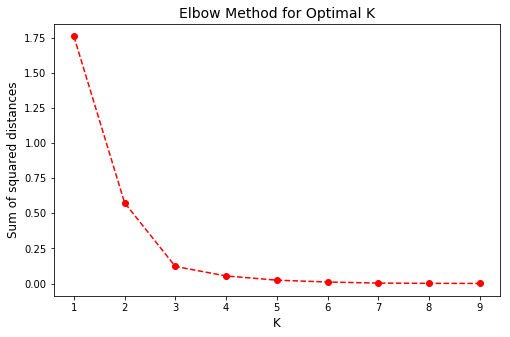

In [51]:
#plot the figure
plt.figure(figsize=(8, 5))
plt.plot(K, Sum_of_squared_distances, 'bx-', color='red', linestyle = '--', marker = 'o')
plt.xlabel('K', fontsize=12)
plt.ylabel('Sum of squared distances', fontsize=12)
plt.title('Elbow Method for Optimal K', fontsize=14)

plt.show()

### B. Use K-means with optimal K to determine the clusters and put the information in a dataframe

In [52]:
#optimal K is where the elbow would be if the graph was an arm
#now set up K-means using optimal K
kclusters = 3

kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(cs_clustering)

In [53]:
#check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([0, 0, 0, 0, 0, 1, 0, 1, 1, 0], dtype=int32)

In [54]:
#create a new dataframe that includes the the mean of the frequency occurance of coffee shops and a column 'Cluster Labels' to show the clusters 
cs_merged = CT_cs.copy()
cs_merged["Cluster Labels"] = kmeans.labels_
cs_merged = cs_merged[['Street Code', 'Cluster Labels', 'Coffee Shop']]
cs_merged.head(10)

,Street Code,Cluster Labels,Coffee Shop
0,7100,0,0.000000
1,7405,0,0.000000
2,7441,0,0.000000
3,7455,0,0.000000
4,7460,0,0.000000
5,7490,1,0.080000
6,7500,0,0.000000
7,7530,1,0.072727
8,7550,1,0.055556
9,7560,0,0.000000


In [55]:
#and add the geographical coordinates of the Street Codes to that dataframe
Coffee_Shops = cs_merged.join(latlong_df.set_index('STR-CODE'), on = 'Street Code')
Coffee_Shops.head(10)

,Street Code,Cluster Labels,Coffee Shop,Latitude,Longitude
0,7100,0,0.000000,-33.987809,18.667149
1,7405,0,0.000000,-33.926604,18.498313
2,7441,0,0.000000,-33.844994,18.522595
3,7455,0,0.000000,-33.944727,18.532317
4,7460,0,0.000000,-33.908873,18.550382
5,7490,1,0.080000,-33.955570,18.587988
6,7500,0,0.000000,-33.891997,18.586241
7,7530,1,0.072727,-33.879257,18.631784
8,7550,1,0.055556,-33.840950,18.659587
9,7560,0,0.000000,-33.875597,18.693069


### C. Exploring the clusters

##### Cluster 0

In [56]:
Coffee_Shops.loc[Coffee_Shops['Cluster Labels'] == 0]

,Street Code,Cluster Labels,Coffee Shop,Latitude,Longitude
0,7100,0,0.0,-33.987809,18.667149
1,7405,0,0.0,-33.926604,18.498313
2,7441,0,0.0,-33.844994,18.522595
3,7455,0,0.0,-33.944727,18.532317
4,7460,0,0.0,-33.908873,18.550382
6,7500,0,0.0,-33.891997,18.586241
9,7560,0,0.0,-33.875597,18.693069
12,7750,0,0.0,-34.025756,18.546565
13,7764,0,0.0,-33.968128,18.533450
16,7785,0,0.0,-34.044635,18.621254


#### => Cluster 0: These are the Street Codes with no presence of Coffee Shops

##### Cluster 1

In [57]:
Coffee_Shops.loc[Coffee_Shops['Cluster Labels'] == 1]

,Street Code,Cluster Labels,Coffee Shop,Latitude,Longitude
5,7490,1,0.080000,-33.955570,18.587988
7,7530,1,0.072727,-33.879257,18.631784
8,7550,1,0.055556,-33.840950,18.659587
10,7700,1,0.064516,-33.959726,18.478190
11,7708,1,0.060606,-33.988448,18.466615
14,7780,1,0.100000,-33.989175,18.512072
21,7945,1,0.038462,-34.068995,18.468739
22,7975,1,0.058824,-34.128527,18.394639
23,8001,1,0.100000,-33.922468,18.416742
24,8005,1,0.051282,-33.931819,18.376121


#### => Cluster 1: These are the Street Codes with a moderate number of Coffee Shops

##### Cluster 2

In [58]:
Coffee_Shops.loc[Coffee_Shops['Cluster Labels'] == 2]

,Street Code,Cluster Labels,Coffee Shop,Latitude,Longitude
15,7784,2,0.200000,-34.039174,18.675445
19,7925,2,0.151163,-33.931338,18.455402


#### => Cluster 2: These are the Street Codes with a high number Coffee Shops

### D. Visualization of the clusters

In [59]:
#generate a map showing the different clusters
#using the geographical coordinates of Cape Town city centre to center the map around that area for a more compact result
latitude = -33.922468
longitude = 18.416742
map_cs_clusters =folium.Map(location = [latitude, longitude], zoom_start = 10, width = 800, height = 600)

x = np.arange(kclusters)
ys = [i+x+(i*x)**2 for i in range (kclusters)]
colors_array = cm.gist_rainbow(np.linspace(0, 1, len(ys)))
gist_rainbow = [colors.rgb2hex(i)for i in colors_array]

marker_colors = []
for lat, lon, poi, cluster in zip(Coffee_Shops['Latitude'], Coffee_Shops['Longitude'], Coffee_Shops['Street Code'], Coffee_Shops[ 'Cluster Labels']):
    label = folium.Popup(str(poi)+', Cluster: '+str(cluster), parse_html=True)
    folium.CircleMarker([lat, lon], radius=7, popup=label, color=gist_rainbow[cluster -1], fill=True, fill_color= gist_rainbow[cluster -1],fill_opacity=0.9).add_to(map_cs_clusters)
print('\n')
print('PINK = Cluster 0, RED = Cluster 1, GREEN = Cluster 2')      
map_cs_clusters



PINK = Cluster 0, RED = Cluster 1, GREEN = Cluster 2


--------------------------------------------------------------------------------------------------------

## 8. Exploring if there are Street Codes in cluster 0 which we can recommend for opening a Coffee Shop

### A. Determine the Street Codes that are situated within 15km radius from the city centre and are in Cluster 0

In [60]:
#Coordinates City Center, Street Code 8100
CClat = -33.922468
CClon = 18.416742


#Distance function between two lat/lon
def getDist(lat1,lon1,lat2,lon2):
  R = 6373.0

  lat1 = radians(lat1)
  lon1 = radians(lon1)
  lat2 = radians(lat2)
  lon2 = radians(lon2)

  dlon = lon2 - lon1
  dlat = lat2 - lat1

  a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
  c = 2 * atan2(sqrt(a), sqrt(1 - a))

  return R * c

#Apply distance function to dataframe
Coffee_Shops['Distance(km)']=list(map(lambda k: getDist(Coffee_Shops.loc[k]['Latitude'],Coffee_Shops.loc[k]['Longitude'],CClat,CClon), Coffee_Shops.index))

#This will give all locations within radius of 15 km
CS_within15 = Coffee_Shops[Coffee_Shops['Distance(km)']<15]
CS_within15.head(10)

,Street Code,Cluster Labels,Coffee Shop,Latitude,Longitude,Distance(km)
1,7405,0,0.000000,-33.926604,18.498313,7.542683
2,7441,0,0.000000,-33.844994,18.522595,13.030715
3,7455,0,0.000000,-33.944727,18.532317,10.949512
4,7460,0,0.000000,-33.908873,18.550382,12.427999
10,7700,1,0.064516,-33.959726,18.478190,7.023276
11,7708,1,0.060606,-33.988448,18.466615,8.662150
13,7764,0,0.000000,-33.968128,18.533450,11.906517
14,7780,1,0.100000,-33.989175,18.512072,11.506992
17,7800,0,0.000000,-34.019579,18.474911,12.060983
18,7806,0,0.000000,-34.012013,18.400462,10.072664


In [61]:
#define a new dataframe for Street Codes within the 15km radius ánd in Cluster 0
StrCodes_C0_radius15 = CS_within15.loc[CS_within15['Cluster Labels'] == 0]
StrCodes_C0_radius15 = StrCodes_C0_radius15.reset_index(drop=True)
print('\n')
print('Street Codes within 15km from city centre AND in Cluster 0:')
StrCodes_C0_radius15



Street Codes within 15km from city centre AND in Cluster 0:


,Street Code,Cluster Labels,Coffee Shop,Latitude,Longitude,Distance(km)
0,7405,0,0.0,-33.926604,18.498313,7.542683
1,7441,0,0.0,-33.844994,18.522595,13.030715
2,7455,0,0.0,-33.944727,18.532317,10.949512
3,7460,0,0.0,-33.908873,18.550382,12.427999
4,7764,0,0.0,-33.968128,18.533450,11.906517
5,7800,0,0.0,-34.019579,18.474911,12.060983
6,7806,0,0.0,-34.012013,18.400462,10.072664


### B. Extract the 10 most common venues for the target Street Codes and put them in a dataframe

In [64]:
#I'll use the dataframe CT_grouped with information on the mean frequency occurence of venues in each Street Code
CT_grouped.head()

,Street Code,African Restaurant,Airport,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Arcade,Art Gallery,Art Museum,...,Thai Restaurant,Theater,Track,Trail,Train,Train Station,Vegetarian / Vegan Restaurant,Vineyard,Warehouse Store,Wine Bar
0,7100,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
1,7405,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.028571,0.0,0.028571,0.0,0.0,0.057143,0.0,0.0,0.0,0.0
2,7441,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.1,0.0
3,7455,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
4,7460,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.000000,0.0,0.0,0.025641,0.0,0.0,0.0,0.0


In [65]:
#convert column 'Street Code' back into type int to be able to create a new dataframe 
CT_grouped['Street Code'] = CT_grouped['Street Code'].astype(int)

In [66]:
#write a function to sort the venues in descending order
def return_most_common_venues(row, nr_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending = False)
    return row_categories_sorted.index.values[0:nr_top_venues]

In [67]:
#create a new dataframe and display the top 10 venues for each neighbourhood
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

In [68]:
#create columns according to number of top venues
columns = ['Street Code']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

In [69]:
#create a new dataframe
strcode_venues_sorted = pd.DataFrame(columns=columns)
strcode_venues_sorted['Street Code'] = CT_grouped['Street Code']

for ind in np.arange(CT_grouped.shape[0]):
    strcode_venues_sorted.iloc[ind, 1:] = return_most_common_venues(CT_grouped.iloc[ind, :], num_top_venues)

strcode_venues_sorted.head(7)

,Street Code,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,7100,Home Service,Soccer Field,Pool,Print Shop,Liquor Store,Arts & Crafts Store,Wine Bar,Dog Run,Fast Food Restaurant,Farmers Market
1,7405,Furniture / Home Store,Grocery Store,Gym,Train Station,Burger Joint,Café,Fast Food Restaurant,Seafood Restaurant,Pharmacy,Playground
2,7441,Pizza Place,Gay Bar,Shopping Mall,Convenience Store,Stadium,Garden Center,Chinese Restaurant,Fast Food Restaurant,Dance Studio,Warehouse Store
3,7455,Convenience Store,Gas Station,Seafood Restaurant,Fast Food Restaurant,Farmers Market,Steakhouse,Business Service,Shopping Mall,Pizza Place,Design Studio
4,7460,Fast Food Restaurant,Portuguese Restaurant,Gas Station,Steakhouse,Casino,Bowling Alley,Diner,Hotel,Seafood Restaurant,Skating Rink
5,7490,Airport Lounge,Rental Car Location,Gas Station,Coffee Shop,Airport Terminal,Gastropub,Shopping Mall,Seafood Restaurant,Steakhouse,Burger Joint
6,7500,Grocery Store,Shopping Mall,Fast Food Restaurant,Supermarket,Golf Course,Hotel,Gas Station,Liquor Store,Convenience Store,Portuguese Restaurant


In [70]:
#showing the 10 most common venues in the target Street Codes within the 15km radius ánd in Cluster 0
Radius15_C0_venues = strcode_venues_sorted.merge(StrCodes_C0_radius15.set_index('Street Code'), on='Street Code')
Radius15_C0_venues.drop(['Coffee Shop','Distance(km)','Cluster Labels'], axis=1)

,Street Code,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Latitude,Longitude
0,7405,Furniture / Home Store,Grocery Store,Gym,Train Station,Burger Joint,Café,Fast Food Restaurant,Seafood Restaurant,Pharmacy,Playground,-33.926604,18.498313
1,7441,Pizza Place,Gay Bar,Shopping Mall,Convenience Store,Stadium,Garden Center,Chinese Restaurant,Fast Food Restaurant,Dance Studio,Warehouse Store,-33.844994,18.522595
2,7455,Convenience Store,Gas Station,Seafood Restaurant,Fast Food Restaurant,Farmers Market,Steakhouse,Business Service,Shopping Mall,Pizza Place,Design Studio,-33.944727,18.532317
3,7460,Fast Food Restaurant,Portuguese Restaurant,Gas Station,Steakhouse,Casino,Bowling Alley,Diner,Hotel,Seafood Restaurant,Skating Rink,-33.908873,18.550382
4,7764,Fast Food Restaurant,Pizza Place,Nightclub,Convenience Store,Burger Joint,Bakery,Stadium,Steakhouse,Indian Restaurant,Seafood Restaurant,-33.968128,18.533450
5,7800,Grocery Store,Fast Food Restaurant,Golf Course,Pharmacy,Pizza Place,Café,Thai Restaurant,Bakery,Performing Arts Venue,Portuguese Restaurant,-34.019579,18.474911
6,7806,Vineyard,Café,Flower Shop,Playground,Trail,Restaurant,French Restaurant,Tapas Restaurant,Wine Bar,Event Space,-34.012013,18.400462


In [71]:
#add the lat/long columns and put all the columns in the right order
Recommendation_df = Radius15_C0_venues.join(CT_df.set_index('STR-CODE'), on = 'Street Code').reindex(columns=['Street Code','Latitude','Longitude','1st Most Common Venue','2nd Most Common Venue',
                                                                                                        '3rd Most Common Venue','4th Most Common Venue','5th Most Common Venue',
                                                                                                        '6th Most Common Venue','7th Most Common Venue','8th Most Common Venue',
                                                                                                        '9th Most Common Venue','10th Most Common Venue'])


print('\n')
print('THE FINAL DATAFRAME WITH STREET CODES THAT ARE SUITABLE FOR RECOMMENDATION (TARGET STREET CODES):')
Recommendation_df



THE FINAL DATAFRAME WITH STREET CODES THAT ARE SUITABLE FOR RECOMMENDATION (TARGET STREET CODES):


,Street Code,Latitude,Longitude,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,7405,-33.926604,18.498313,Furniture / Home Store,Grocery Store,Gym,Train Station,Burger Joint,Café,Fast Food Restaurant,Seafood Restaurant,Pharmacy,Playground
1,7441,-33.844994,18.522595,Pizza Place,Gay Bar,Shopping Mall,Convenience Store,Stadium,Garden Center,Chinese Restaurant,Fast Food Restaurant,Dance Studio,Warehouse Store
2,7455,-33.944727,18.532317,Convenience Store,Gas Station,Seafood Restaurant,Fast Food Restaurant,Farmers Market,Steakhouse,Business Service,Shopping Mall,Pizza Place,Design Studio
3,7460,-33.908873,18.550382,Fast Food Restaurant,Portuguese Restaurant,Gas Station,Steakhouse,Casino,Bowling Alley,Diner,Hotel,Seafood Restaurant,Skating Rink
4,7764,-33.968128,18.533450,Fast Food Restaurant,Pizza Place,Nightclub,Convenience Store,Burger Joint,Bakery,Stadium,Steakhouse,Indian Restaurant,Seafood Restaurant
5,7800,-34.019579,18.474911,Grocery Store,Fast Food Restaurant,Golf Course,Pharmacy,Pizza Place,Café,Thai Restaurant,Bakery,Performing Arts Venue,Portuguese Restaurant
6,7806,-34.012013,18.400462,Vineyard,Café,Flower Shop,Playground,Trail,Restaurant,French Restaurant,Tapas Restaurant,Wine Bar,Event Space


In [72]:
#location of the target Street Codes
map_C0_radius15 =folium.Map(location = [CClat, CClon], zoom_start = 11, width = 900, height = 800)

marker_colors = []
for lat, lon, poi in zip(Recommendation_df['Latitude'], Recommendation_df['Longitude'], Recommendation_df['Street Code']):
    label = folium.Popup(str(poi), parse_html=True)
    folium.CircleMarker([lat, lon], radius=7, popup=label, color=gist_rainbow[cluster -1], fill=True, fill_color=gist_rainbow[cluster -1] ,fill_opacity=0.9).add_to(map_C0_radius15)   
    
map_C0_radius15

-------------------------------------------------------------------------------------------------------------------------

## 9. Exploring every ***first*** suburb in the target Street Codes that are suitable for recommendation

### A. 7405

In [73]:
#check the suburbs in 7405
Suburbs7405_df = Suburbs_CT.loc[Suburbs_CT['STR-CODE'] == '7405']
Suburbs7405_df.reset_index(drop=True)

,SUBURB,STR-CODE
0,MAITLAND,7405
1,PAARDEN ISLAND,7405
2,PAARDENEILAND,7405
3,PINELANDS,7405
4,YSTERPLAAT,7405


In [74]:
#scrape a website on the first suburb, Maitland
resMaitland = requests.get('https://blog.rawson.co.za/spotlight-on-maitland-cape-town')

In [75]:
Maitland_CT = BeautifulSoup(resMaitland.text, 'html.parser')

Text_Maitland = []
for i in Maitland_CT.select('p'):
    Text_Maitland.append(i.getText())

Maitland_text = pd.DataFrame(Text_Maitland)
Maitland_text.columns = ['Alineas']
Maitland_text.head(7)

,Alineas
0,\nCommercial\n
1,The suburbs of Maitland and Kensington in Cape...
2,Location and access
3,Two good points worth considering when looking...
4,“The Cape Town International airport lies with...
5,Commercial property
6,"As previously mentioned, Maitland is comprised..."


In [76]:
Maitland = Maitland_text.iloc[1:11]

In [77]:
text_Maitland = " ".join(alinea for alinea in Maitland.Alineas)

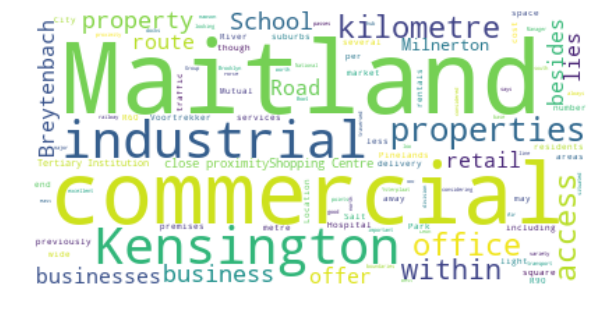

In [78]:
stopwords=set(STOPWORDS)
stopwords.update(['well', 'lie', 'Cape', 'Town', 'area'])

wordcloud_W = WordCloud(background_color ='white', max_words = 100, stopwords = stopwords).generate(text_Maitland)

# Display the generated image:
plt.figure(figsize=(10, 8))
plt.imshow(wordcloud_W, interpolation='bilinear')
plt.axis("off")

plt.show()

### B. 7441

In [79]:
#check the suburbs in 7441
Suburbs7441_df = Suburbs_CT.loc[Suburbs_CT['STR-CODE'] == '7441']
Suburbs7441_df.reset_index(drop=True)

,SUBURB,STR-CODE
0,BOTHASIG,7441
1,EDGEMEAD,7441
2,MELKBOS,7441
3,MELKBOSSTRAND,7441
4,MILNERTON,7441
5,TABLE VIEW,7441


In [80]:
resBothasig = requests.get('https://www.sa-venues.com/attractionswc/bothasig.php')

In [81]:
Bothasig_CT = BeautifulSoup(resBothasig.text, 'html.parser')

Text_Bothasig = []
for i in Bothasig_CT.select('p'):
    Text_Bothasig.append(i.getText())

Bothasig_text = pd.DataFrame(Text_Bothasig)
Bothasig_text.columns = ['Alineas']
Bothasig_text.head(7)

,Alineas
0,"In the Northern Suburbs of Cape Town, surround..."
1,Bothasig was named after the former Prime Mini...
2,It is a fantastic place from which to explore ...
3,Views of Table Mountain in the distance are po...
4,Bothasig is neighbour to Edgemead and Milnerto...
5,The Cape Town International Airport is easily ...
6,"Located in Bothasig, Inn Da Mood offers comfor..."


In [82]:
Bothasig = Bothasig_text.iloc[0:5]

In [83]:
text_Bothasig = " ".join(alinea for alinea in Bothasig.Alineas)

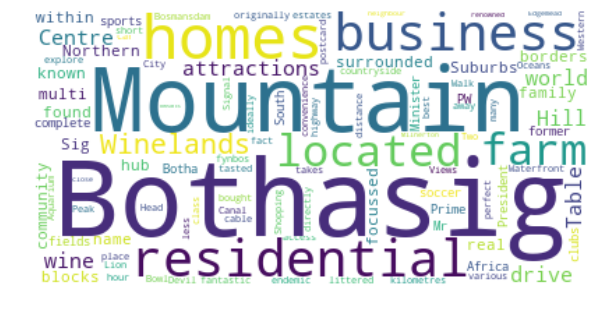

In [84]:
#defining stopwords for the WordClouds
stopwords=set(STOPWORDS)
stopwords.update(['Cape','Town','minutes','area','named','faceted','state','earned','terms'])

wordcloudBH = WordCloud(background_color ='white', max_words = 100, stopwords=stopwords).generate(text_Bothasig)

# Display the generated image:
plt.figure(figsize=(10, 8))
plt.imshow(wordcloudBH, interpolation='bilinear')
plt.axis("off")

plt.show()

### C. 7455

In [85]:
#check the suburbs in 7455
Suburbs7455_df = Suburbs_CT.loc[Suburbs_CT['STR-CODE'] == '7455']
Suburbs7455_df.reset_index(drop=True).head(7)

,SUBURB,STR-CODE
0,LANGA,7455
1,LANGA ZONE 1,7455
2,LANGA SONE 1,7455
3,LANGA ZONE 10,7455
4,LANGA SONE 10,7455
5,LANGA ZONE 11,7455
6,LANGA SONE 11,7455


In [86]:
resLanga = requests.get('https://www.sa-venues.com/attractionswc/langa.php')

In [87]:
Langa_CT = BeautifulSoup(resLanga.text, 'html.parser')

Text_Langa = []
for i in Langa_CT.select('p'):
    Text_Langa.append(i.getText())

Langa_text = pd.DataFrame(Text_Langa)
Langa_text.columns = ['Alineas']
Langa_text.head(6)

,Alineas
0,Set just 15 to 20 kilometres from the centre o...
1,"An area made up of infamous singles quarters, ..."
2,"Langa, the sun, was created in 1901 in the wak..."
3,Today the township of Langa may still be divid...
4,You can eat at Eziko (cooking place) Catering ...
5,1 Review from SA-Venues.com travellers. All re...


In [88]:
Langa = Langa_text.iloc[0:4]

In [89]:
text_Langa = " ".join(alinea for alinea in Langa.Alineas)

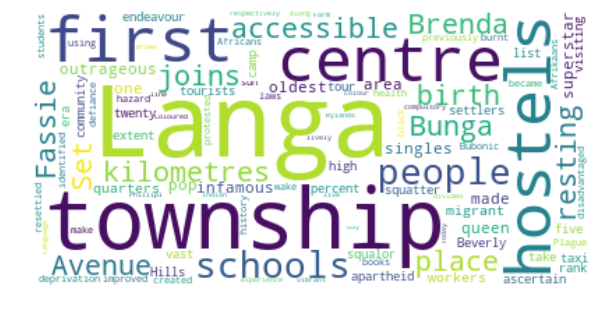

In [90]:
#defining stopwords for the WordClouds
stopwords=set(STOPWORDS)
stopwords.update(['Cape','Town','still','pass','N2'])

wordcloudDR = WordCloud(background_color ='white', max_words = 100, stopwords=stopwords).generate(text_Langa)

# Display the generated image:
plt.figure(figsize=(10, 8))
plt.imshow(wordcloudDR, interpolation='bilinear')
plt.axis("off")

plt.show()

### D. 7460

In [91]:
#check the suburbs in 7460
Suburbs7460_df = Suburbs_CT.loc[Suburbs_CT['STR-CODE'] == '7460']
Suburbs7460_df.reset_index(drop=True)

,SUBURB,STR-CODE
0,MONTE VISTA,7460


In [92]:
#scrape Wikipedia's website on Monte Vista, it has little information (and there are no other websites with more information)
resMonteVista = requests.get('https://en.wikipedia.org/wiki/Monte_Vista,_Cape_Town')

In [93]:
MonteVista_CT = BeautifulSoup(resMonteVista.text, 'html.parser')

Text_MonteVista = []
for i in MonteVista_CT.select('p'):
    Text_MonteVista.append(i.getText())

MonteVista_text = pd.DataFrame(Text_MonteVista)
MonteVista_text.columns = ['Alineas']
MonteVista_text

,Alineas
0,"Monte Vista is a suburb of Cape Town, South Af..."
1,Monte Vista Primary School was built in the 19...


In [94]:
text_MonteVista = " ".join(alinea for alinea in MonteVista_text.Alineas)

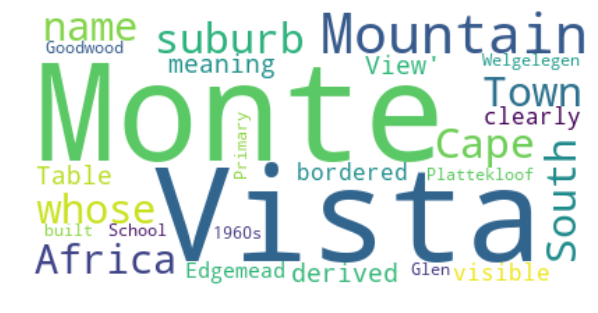

In [95]:
stopwords=set(STOPWORDS)
stopwords.update([''])

wordcloud_W = WordCloud(background_color ='white', max_words = 100, stopwords = stopwords).generate(text_MonteVista)

# Display the generated image:
plt.figure(figsize=(10, 8))
plt.imshow(wordcloud_W, interpolation='bilinear')
plt.axis("off")

plt.show()

### E. 7764

In [96]:
#check the suburbs in 7764
Suburbs7764_df = Suburbs_CT.loc[Suburbs_CT['STR-CODE'] == '7764']
Suburbs7764_df.reset_index(drop=True)

,SUBURB,STR-CODE
0,ATHLONE,7764
1,ATHLONE INDUSTRIA 1,7764
2,ATHLONE INDUSTRIA 2,7764
3,GATESVILLE,7764


In [97]:
resAthlone = requests.get('https://www.sa-venues.com/attractionswc/athlone.php')

In [98]:
Athlone_CT = BeautifulSoup(resAthlone.text, 'html.parser')

Text_Athlone = []
for i in Athlone_CT.select('p'):
    Text_Athlone.append(i.getText())

Athlone_text = pd.DataFrame(Text_Athlone)
Athlone_text.columns = ['Alineas']
Athlone_text.head()

,Alineas
0,Athlone lies to the east of the city centre in...
1,Athlone is a large suburb that contains within...
2,Ask anyone where Athlone is and they will refe...
3,Athlone's second major landmark is the Athlone...
4,Brookdale House offers Bed & Breakfast accommo...


In [99]:
Athlone = Athlone_text.iloc[0:3]

In [100]:
text_Athlone = " ".join(alinea for alinea in Athlone.Alineas)

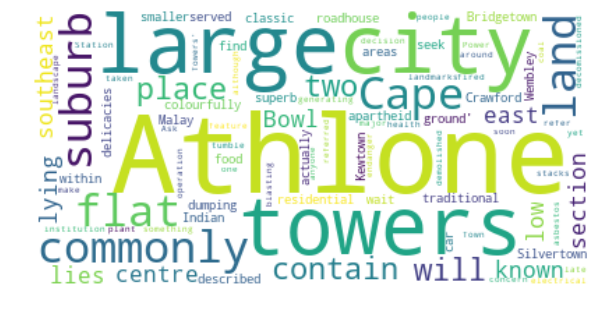

In [101]:
stopwords=set(STOPWORDS)
stopwords.update([''])

wordcloud_W = WordCloud(background_color ='white', max_words = 100, stopwords = stopwords).generate(text_Athlone)

# Display the generated image:
plt.figure(figsize=(10, 8))
plt.imshow(wordcloud_W, interpolation='bilinear')
plt.axis("off")

plt.show()

### F. 7800

In [102]:
#check the suburbs in 7800
Suburbs7800_df = Suburbs_CT.loc[Suburbs_CT['STR-CODE'] == '7800']
Suburbs7800_df.reset_index(drop=True)

,SUBURB,STR-CODE
0,DIEP RIVER,7800
1,DIEP RIVIER,7800
2,OTTERY,7800
3,PLUMSTEAD,7800
4,SOUTHFIELD,7800
5,WYNBERG,7800


In [103]:
resDiepRiver = requests.get('https://www.sa-venues.com/attractionswc/diep-river.php')

In [104]:
DiepRiver_CT = BeautifulSoup(resDiepRiver.text, 'html.parser')

Text_DiepRiver = []
for i in DiepRiver_CT.select('p'):
    Text_DiepRiver.append(i.getText())

DiepRiver_text = pd.DataFrame(Text_DiepRiver)
DiepRiver_text.columns = ['Alineas']
DiepRiver_text.head()

,Alineas
0,"Diep River in Cape Town, named after the river..."
1,Diep River is secretly coveted by its neighbou...
2,"Together with areas like lower Wynberg, Rondeb..."
3,In the lower reaches of Diep River you will fi...
4,"Located in Tokai, Villa Karibu offers comforta..."


In [105]:
DiepRiver = DiepRiver_text.iloc[0:3]

In [106]:
text_DeepRiver = " ".join(alinea for alinea in DiepRiver.Alineas)

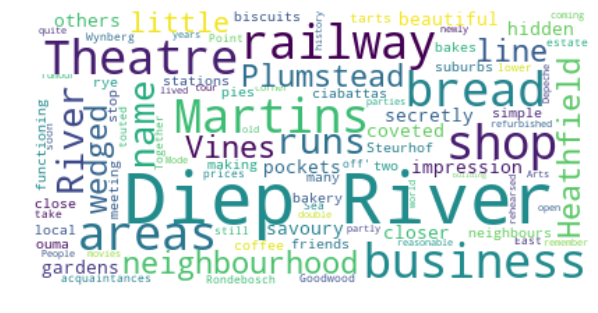

In [107]:
#defining stopwords for the WordClouds
stopwords=set(STOPWORDS)
stopwords.update(['Main','suburb','particularly','one', 'false','well','back','commute','around','known','less','deep','give','possibly','whilst','whole','lies','named','anything','lot','Road','effortless','Cape','Town','area','agents','bill','needs','scrumptious','homes'])

wordcloudDR = WordCloud(background_color ='white', max_words = 100, stopwords=stopwords).generate(text_DeepRiver)

# Display the generated image:
plt.figure(figsize=(10, 8))
plt.imshow(wordcloudDR, interpolation='bilinear')
plt.axis("off")

plt.show()

### G. 7806

In [108]:
#check the suburbs in 7806
Suburbs7806_df = Suburbs_CT.loc[Suburbs_CT['STR-CODE'] == '7806']
Suburbs7806_df.reset_index(drop=True)

,SUBURB,STR-CODE
0,CONSTANTIA,7806
1,HOUT BAY,7806
2,HOUTBAAI,7806


In [109]:
resConstantia = requests.get('https://www.sa-venues.com/attractionswc/constantia.php')

In [110]:
Constantia_CT = BeautifulSoup(resConstantia.text, 'html.parser')

Text_Constantia = []
for i in Constantia_CT.select('p'):
    Text_Constantia.append(i.getText())

Constantia_text = pd.DataFrame(Text_Constantia)
Constantia_text.columns = ['Alineas']
Constantia_text.head()

,Alineas
0,Luxury accommodation in Constantia awaits disc...
1,In Constantia you still find a smattering of c...
2,Many parts of Constantia lie bordering or clos...
3,Youre only 20 minutes from the centre of Cape...
4,The Kirstenbosch Botanical Gardens are close b...


In [111]:
Constantia = Constantia_text.iloc[0:4]

In [112]:
text_Constantia = " ".join(alinea for alinea in Constantia.Alineas)

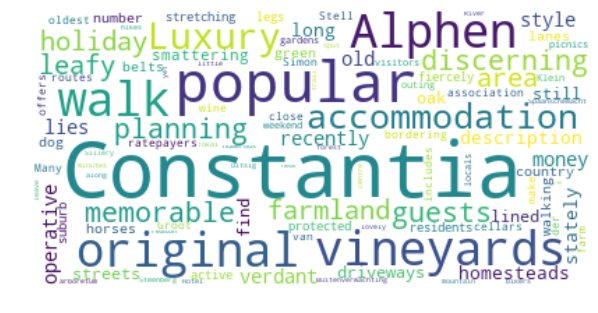

In [113]:
#defining stopwords for the WordClouds
stopwords=set(STOPWORDS)
stopwords.update(['Cape','Town','dominated','fairly','awaits','lie','include','one','parts','South','Africa'])

wordcloudC = WordCloud(background_color ='white', max_words = 100, stopwords=stopwords).generate(text_Constantia)

# Display the generated image:
plt.figure(figsize=(10, 8))
plt.imshow(wordcloudC, interpolation='bilinear')
plt.axis("off")

plt.show()

# THE END

---------------------------------------------------------------------------------------------------------------------------------------------